In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import re
import time
import datetime
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensor

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

import numba
import ast
import cv2
from glob import glob

from numba import jit
from typing import List, Union, Tuple

In [4]:
train_df = pd.read_csv("/content/drive/My Drive/Data_Set/train.csv")
train_df

,class_id,xmin,ymin,xmax,ymax,label
0,00000.jpg,0.000000,41.558442,597.922078,571.428571,squid_peanut
1,00000.jpg,558.441558,137.142857,740.259740,344.935065,cidar
2,00000.jpg,715.324675,69.610390,906.493506,395.844156,diget_ori
3,00000.jpg,902.337662,21.818182,1082.077922,362.597403,welchs
4,00000.jpg,270.649351,431.168831,505.454545,646.233766,diget_choco
...,...,...,...,...,...,...
14174,02001.jpg,621.245136,241.991701,815.486381,570.622407,diget_ori
14175,02001.jpg,779.626459,239.004149,1066.505837,662.240664,jjolbyung_noodle
14176,02001.jpg,1042.599222,252.946058,1238.832685,593.526971,welchs
14177,02001.jpg,563.470817,607.468880,1232.856031,835.518672,zec


In [5]:
image_ids = train_df['class_id'].unique()
print(len(image_ids))

1602


In [6]:
valid_ids = image_ids[:602]
train_ids = image_ids[602:]

In [7]:
valid_df = train_df[train_df['class_id'].isin(valid_ids)]  
train_df = train_df[train_df['class_id'].isin(train_ids)]

In [34]:
class customDataSet(object):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        self.image_ids = dataframe['class_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __len__(self):
        return self.image_ids.shape[0]
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        records = self.df[self.df['class_id'] == image_id]
        image_name = image_id.split(".")[0]
        
        image = cv2.imread(f'{self.image_dir}/{image_name}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target, image_id

In [35]:
# Albumentations
def get_train_transform():
    return A.Compose([
#         A.Flip(0.5),
#         ToTensorV2(p=1.0)
        ToTensor(),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
#         ToTensorV2(p=1.0)
        ToTensor(),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## 모델

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [36]:
num_classes = 23 # 22 class + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [37]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [38]:
def collate_fn(batch):
    return tuple(zip(*batch))

DIR_TRAIN = "/content/drive/My Drive/Data_Set/train"
train_dataset = customDataSet(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = customDataSet(valid_df, DIR_TRAIN, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

In [39]:
train_dataset[0]

(tensor([[[0.0510, 0.0510, 0.0510,  ..., 0.7098, 0.7098, 0.7098],
          [0.0510, 0.0510, 0.0510,  ..., 0.7098, 0.7098, 0.7098],
          [0.0510, 0.0510, 0.0510,  ..., 0.7098, 0.7098, 0.7098],
          ...,
          [0.0510, 0.0510, 0.0510,  ..., 0.6706, 0.6824, 0.6980],
          [0.0510, 0.0510, 0.0510,  ..., 0.6706, 0.6824, 0.6980],
          [0.0510, 0.0510, 0.0510,  ..., 0.6706, 0.6824, 0.6980]],
 
         [[0.0510, 0.0510, 0.0510,  ..., 0.7373, 0.7373, 0.7373],
          [0.0510, 0.0510, 0.0510,  ..., 0.7373, 0.7373, 0.7373],
          [0.0510, 0.0510, 0.0510,  ..., 0.7373, 0.7373, 0.7373],
          ...,
          [0.0510, 0.0510, 0.0510,  ..., 0.6784, 0.6902, 0.7059],
          [0.0510, 0.0510, 0.0510,  ..., 0.6784, 0.6902, 0.7059],
          [0.0510, 0.0510, 0.0510,  ..., 0.6784, 0.6902, 0.7059]],
 
         [[0.0510, 0.0510, 0.0510,  ..., 0.7686, 0.7686, 0.7686],
          [0.0510, 0.0510, 0.0510,  ..., 0.7686, 0.7686, 0.7686],
          [0.0510, 0.0510, 0.0510,  ...,

In [62]:
valid_dataset[0]

(tensor([[[0.7098, 0.7059, 0.7059,  ..., 0.7137, 0.7137, 0.7137],
          [0.7098, 0.7059, 0.7059,  ..., 0.7137, 0.7137, 0.7137],
          [0.7098, 0.7059, 0.7059,  ..., 0.7137, 0.7137, 0.7137],
          ...,
          [0.7725, 0.7725, 0.7725,  ..., 0.0078, 0.0078, 0.0078],
          [0.7725, 0.7725, 0.7725,  ..., 0.0078, 0.0078, 0.0078],
          [0.7725, 0.7725, 0.7725,  ..., 0.0078, 0.0078, 0.0078]],
 
         [[0.7569, 0.7529, 0.7529,  ..., 0.7843, 0.7843, 0.7843],
          [0.7569, 0.7529, 0.7529,  ..., 0.7843, 0.7843, 0.7843],
          [0.7569, 0.7529, 0.7529,  ..., 0.7843, 0.7843, 0.7843],
          ...,
          [0.8706, 0.8706, 0.8706,  ..., 0.0235, 0.0235, 0.0235],
          [0.8706, 0.8706, 0.8706,  ..., 0.0235, 0.0235, 0.0235],
          [0.8706, 0.8706, 0.8706,  ..., 0.0235, 0.0235, 0.0235]],
 
         [[0.8510, 0.8471, 0.8471,  ..., 0.8706, 0.8706, 0.8706],
          [0.8510, 0.8471, 0.8471,  ..., 0.8706, 0.8706, 0.8706],
          [0.8510, 0.8471, 0.8471,  ...,

In [40]:
@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [41]:
@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx, threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold, form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [42]:
!pip install ensemble_boxes

In [43]:
models = [model]
from ensemble_boxes import *

def make_ensemble_predictions(images):
    images = list(image.to(device) for image in images)    
    result = []
    for net in models:
        net.eval()
        outputs = net(images)
        result.append(outputs)
    return result

def run_wbf(predictions, image_index, image_size=1280, iou_thr=0.55, skip_box_thr=0.5, weights=None):
    boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]) for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

## 훈련

In [44]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [45]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

In [46]:
loss_hist = Averager()
best_val = None
es_patience = 2
patience = es_patience
model_path = '/content/drive/My Drive/Model/lotte_model_object_detection.pt'
for epoch in range(num_epochs):
    start_time = time.time()
    itr = 1
    loss_hist.reset()
    model.train()
    for images, targets, image_ids in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if k =='labels' else v.float().to(device) for k, v in t.items()} for t in targets]#[{k: v.double().to(device) if k =='boxes' else v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    #At every epoch we will also calculate the validation IOU
    validation_image_precisions = []
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
    model.eval()
    for images, targets,imageids in valid_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if k =='labels' else v.float().to(device) for k, v in t.items()} for t in targets]
        #outputs = model(images) 
        
        predictions = make_ensemble_predictions(images)
   
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = boxes.astype(np.int32).clip(min=0, max=1023)
            
            preds = boxes#outputs[i]['boxes'].data.cpu().numpy()
            #scores = outputs[i]['scores'].data.cpu().numpy()
            preds_sorted_idx = np.argsort(scores)[::-1]
            preds_sorted = preds[preds_sorted_idx]
            gt_boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            image_precision = calculate_image_precision(preds_sorted, gt_boxes, thresholds=iou_thresholds, form='coco')

            validation_image_precisions.append(image_precision)
    
    val_iou = np.mean(validation_image_precisions)
    print(f"Epoch #{epoch+1} loss: {loss_hist.value}","Validation IOU: {0:.4f}".format(val_iou),"Time taken :",str(datetime.timedelta(seconds=time.time() - start_time))[:7])
    
    if not best_val:
        best_val = val_iou  # So any validation roc_auc we have is the best one for now
        print("Saving model")
        torch.save(model, model_path)  # Saving the model
        #continue
    if val_iou >= best_val:
        print("Saving model as IOU is increased from",best_val,"to",val_iou)
        best_val = val_iou
        patience = es_patience  # Resetting patience since we have new best validation accuracy
        torch.save(model, model_path)  # Saving current best model torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
    else:
        patience -= 1
        if patience == 0:
            print('Early stopping. Best Validation IOU: {:.3f}'.format(best_val))
            break

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Iteration #50 loss: 1.0034376382827759
Iteration #100 loss: 0.9863066673278809


/usr/local/lib/python3.6/dist-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'thresholds' of function 'calculate_image_precision'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-41-07fbfe3c97f2>", line 86:
@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.6/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Epoch #1 loss: 1.2052269220352172 Validation IOU: 0.4090 Time taken : 0:03:44
Saving model
Saving model as IOU is increased from 0.4090316441140987 to 0.4090316441140987
Iteration #50 loss: 0.5923371911048889
Iteration #100 loss: 0.4448857009410858
Epoch #2 loss: 0.5981998527050019 Validation IOU: 0.6640 Time taken : 0:03:41
Saving model as IOU is increased from 0.4090316441140987 to 0.6639804784278575
Iteration #50 loss: 0.48348239064216614
Iteration #100 loss: 0.35918715596199036
Epoch #3 loss: 0.4275559818744659 Validation IOU: 0.8426 Time taken : 0:03:42
Saving model as IOU is increased from 0.6639804784278575 to 0.8425887330366273
Iteration #50 loss: 0.2675575017929077
Iteration #100 loss: 0.2826795279979706
Epoch #4 loss: 0.3115044701099396 Validation IOU: 0.8678 Time taken : 0:03:40
Saving model as IOU is increased from 0.8425887330366273 to 0.8678002095880003
Iteration #50 loss: 0.29107677936553955
Iteration #100 loss: 0.2900468707084656
Epoch #5 loss: 0.29407769739627837 Valid

In [47]:
tr_model = torch.load(model_path)

## 테스팅

In [56]:
DIR_TEST = "/content/drive/My Drive/Data_Set/test"
test_df = pd.DataFrame()
test_df['image_id'] = np.array([path.split('/')[-1] for path in glob(f'{DIR_TEST}/*.jpg')])

In [57]:
class customTestDataSet(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return self.image_ids.shape[0]

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        image_name = image_id.split(".")[0]

        image = cv2.imread(f'{self.image_dir}/{image_name}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    

In [58]:
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensor()
    ])

In [59]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = customTestDataSet(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [60]:
test_dataset[0]

(tensor([[[0.7137, 0.7137, 0.7098,  ..., 0.6824, 0.6824, 0.6824],
          [0.7137, 0.7137, 0.7098,  ..., 0.6824, 0.6824, 0.6824],
          [0.7098, 0.7098, 0.7059,  ..., 0.6863, 0.6863, 0.6863],
          ...,
          [0.6667, 0.6706, 0.6745,  ..., 0.1333, 0.1294, 0.1294],
          [0.6706, 0.6706, 0.6745,  ..., 0.1333, 0.1294, 0.1294],
          [0.6706, 0.6706, 0.6745,  ..., 0.1333, 0.1294, 0.1294]],
 
         [[0.7333, 0.7333, 0.7294,  ..., 0.7529, 0.7529, 0.7529],
          [0.7333, 0.7333, 0.7294,  ..., 0.7529, 0.7529, 0.7529],
          [0.7294, 0.7294, 0.7255,  ..., 0.7569, 0.7569, 0.7569],
          ...,
          [0.6824, 0.6863, 0.6902,  ..., 0.1333, 0.1294, 0.1294],
          [0.6863, 0.6863, 0.6902,  ..., 0.1333, 0.1294, 0.1294],
          [0.6863, 0.6863, 0.6902,  ..., 0.1333, 0.1294, 0.1294]],
 
         [[0.8118, 0.8118, 0.8078,  ..., 0.8471, 0.8471, 0.8471],
          [0.8118, 0.8118, 0.8078,  ..., 0.8471, 0.8471, 0.8471],
          [0.8157, 0.8157, 0.8118,  ...,

In [61]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [63]:
detection_threshold = 0.5
results = []
outputs = []
test_images = []
for images, image_ids in test_data_loader:
    images = list(image.to(device) for image in images)
    predictions = make_ensemble_predictions(images)

    for i, image in enumerate(images):
        test_images.append(image) # Saving image values
        boxes, scores, labels = run_wbf(predictions, image_index=i)

        boxes = boxes.astype(np.int32).clip(min=0, max=1023)
            
        preds = boxes
        preds_sorted_idx = np.argsort(scores)[::-1]
        preds_sorted = preds[preds_sorted_idx]
        boxes = preds
        
        output = {
            'boxes': boxes,
            'scores': scores
        }

        outputs.append(output) #Saving outputs and scores
        image_id = image_ids[i]

/usr/local/lib/python3.6/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

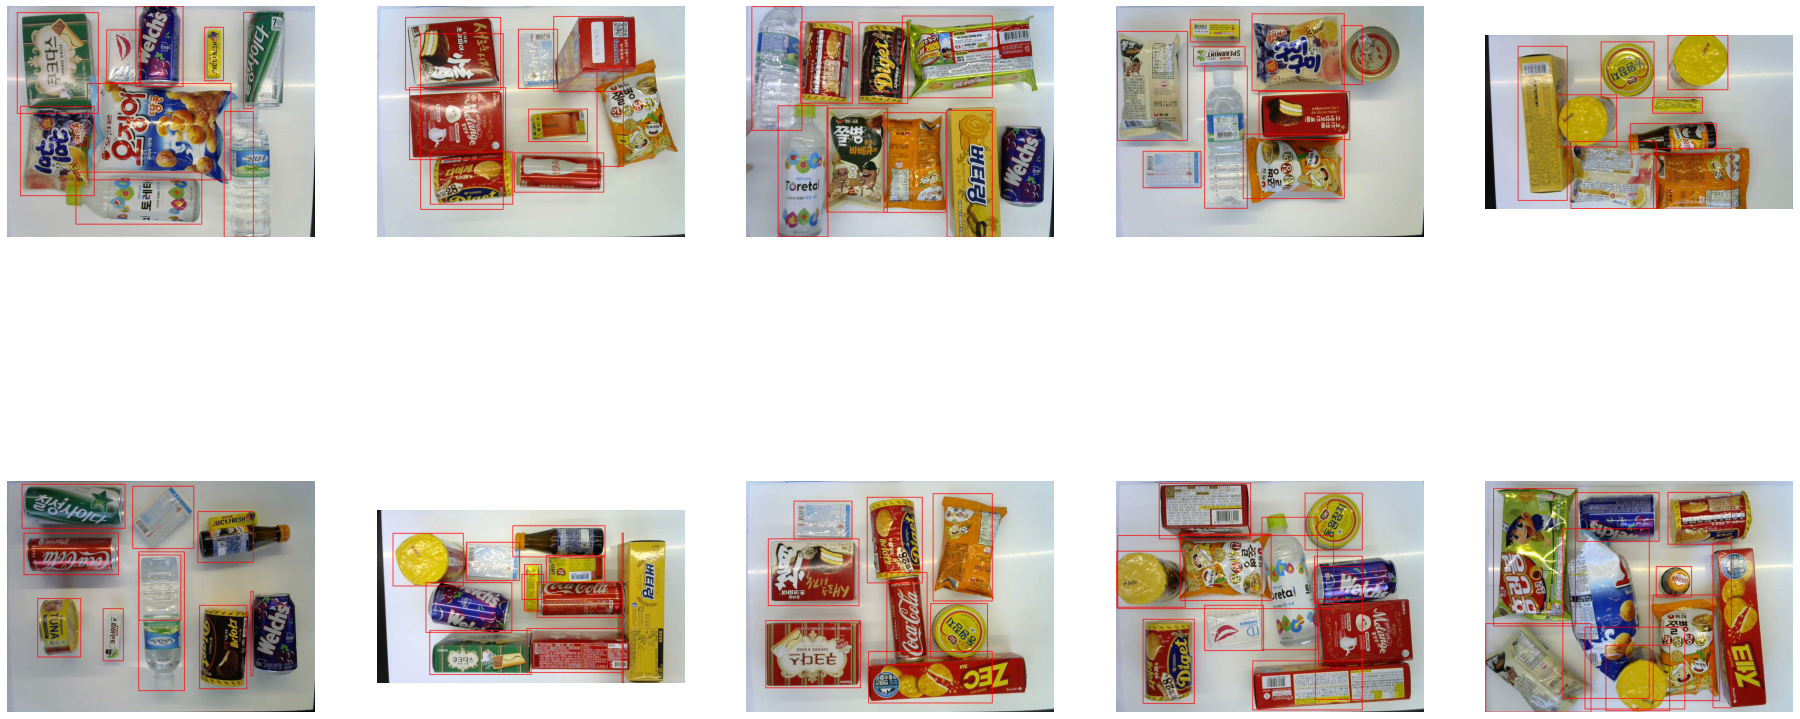

In [64]:
fig, axs = plt.subplots(2, 5, figsize=(32, 16))
axs = axs.ravel()
for i in range(10):
    sample = test_images[i].permute(1,2,0).cpu().numpy()
    boxes = outputs[i]['boxes']
    scores = outputs[i]['scores']
    boxes = boxes[scores >= detection_threshold].astype(np.int32)

    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)

    axs[i].set_axis_off()
    axs[i].imshow(sample)